# Modeling explosive percolation

Replicating the following: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.97.020301

First, need to implement three types of random growth process graphs:
* ER
* AP: Achlioptas : growth process (AP)
* DPR

In [1]:
# Auto-reloads external files any changes are automatically reflected
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import random

import matplotlib.pyplot as plt
%matplotlib inline

View adjacency matrices for each algorithm.

In [5]:
import graphs as g

In [22]:
n = int(50)
# n = int(1e2)
edge_density = 10

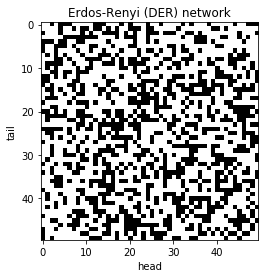

In [32]:
# Directed Erdos-Renyi (DER)
# Need to update to be just ER

ER_viz = g.Graph(n,edge_density*n,'ER')
ER_viz.build()

plt.imshow((ER_viz.edges>0),cmap='binary')
plt.title('Erdos-Renyi (DER) network')
plt.ylabel('tail')
plt.xlabel('head')
plt.show()

18.76



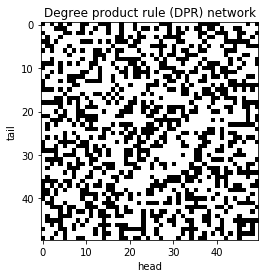

In [36]:
DPR_viz = g.Graph(n,edge_density*n,'DPR')
DPR_viz.build()

plt.imshow((DPR_viz.edges>0),cmap='binary')
plt.title('Degree product rule (DPR) network')
plt.ylabel('tail')
plt.xlabel('head')
plt.show()

In [ ]:
AP_viz = g.Graph(n,edge_density*n,'AP')
AP_viz.build()

plt.imshow((AP_viz.edges>0),cmap='binary')
plt.title('Achlioptas growth process (AP) network')
plt.ylabel('tail')
plt.xlabel('head')
plt.show()

Mechanistically, the DPR is analogous to the Achlioptas process, the difference being that the criteria used to evaluate edges is the product of node degrees (the number of edges attached to a node) rather than cluster sizes.

These are all undirected graphs, which should make the clustering easier.

Next steps:
1. Need to be able to calculate cluster size.
1. Need to get AP working
2. Need to be able to take steps forward in time while calculating cluster size

Make ER using networkx.

In [2]:
N = 1e3 # nodes, 3.6e5 in paper
p = 1.0
t = N*p # edges to add
N_list = list(np.arange(N).astype(int))

In [3]:
def calculate_edge_product(G,edge_tuple):
    return (G.degree[edge_tuple[0]]+1)*(G.degree[edge_tuple[1]]+1)

def calculate_edge_cluster_sizes(G,edge_tuple):
    return len(nx.node_connected_component(G,edge_tuple[0])) + len(nx.node_connected_component(G,edge_tuple[1]))

Probably need to add a check for if an edge already exists in the graph.

In [ ]:
print(list(nx.connected_components(G)))

In [35]:
# ER
C = []
G = nx.Graph()
G.add_nodes_from(np.arange(N))
while len(G.edges)<t:
    proposed_edge = (random.choice(N_list),random.choice(N_list))
    G.add_edge(proposed_edge[0],proposed_edge[1])
    C.append(len(max(nx.connected_component_subgraphs(G), key=len))/N)

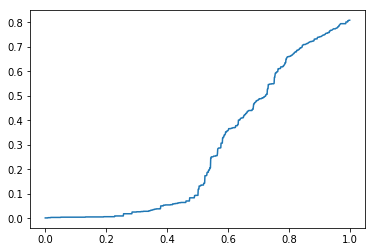

In [36]:
p_range = np.linspace(0,p,int(t))
plt.plot(p_range,C)

In [4]:
m = 2 # candidate edges

# DPR: goes to smallest product of the degrees of connection
C = []
G = nx.Graph()
G.add_nodes_from(np.arange(N))
while len(G.edges)<t:
    proposed_edges = [(random.choice(N_list),random.choice(N_list)) for _ in range(m)]
    proposed_edge_weights = [calculate_edge_product(G,edge_tuple) for edge_tuple in proposed_edges]
    winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
    G.add_edge(winning_edge[0],winning_edge[1])
    C.append(len(max(nx.connected_component_subgraphs(G), key=len))/N)

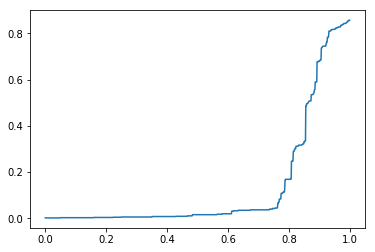

In [7]:
p_range = np.linspace(0,p,int(t))
plt.plot(p_range,C)

In [40]:
m = 2 # candidate edges

# AP: goes to smallest sum of clusters connected to each node
C = []
G = nx.Graph()
G.add_nodes_from(np.arange(N))
while len(G.edges)<t:
    proposed_edges = [(random.choice(N_list),random.choice(N_list)) for _ in range(m)]
    proposed_edge_weights = [calculate_edge_cluster_sizes(G,edge_tuple) for edge_tuple in proposed_edges]
    winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
    G.add_edge(winning_edge[0],winning_edge[1])
    C.append(len(max(nx.connected_component_subgraphs(G), key=len))/N)

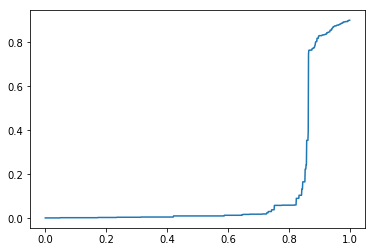

In [41]:
p_range = np.linspace(0,p,int(t))
plt.plot(p_range,C)

In [49]:
def binary_search(G,C,start,end,largest_jump):
    # x-values
    midpoint = int((end-start)/2)
#     print(end-start,midpoint)
    
    # y-values
    head = C[int(start)]
    mid = C[midpoint]
    tail = C[int(end)]
#     print(head,mid,tail)
        
    # If start and end are only one step removed from on another, then search is complete
    if abs(end-start)==1:
        if (tail-head)>largest_jump: largest_jump = (tail-head)
        return largest_jump
    # Check which side of the midpoint the largest jump is on
    elif (mid-head)>(tail-mid):
        if (mid-head)>(len(G.nodes)*0.01):
            largest_jump = (mid-head)
            return binary_search(G,C,start,midpoint,largest_jump)
    elif (tail-mid)>(len(G.nodes)*0.01):
        largest_jump = (tail-mid)
        print('here',midpoint, end, largest_jump)
        return binary_search(G,C,midpoint,end,largest_jump)
    print((tail-mid),(mid-head),len(G.nodes)*0.01)
    return largest_jump

In [40]:
print(len(G.nodes)*0.01)

10.0


In [43]:
t_range = np.arange(t)
start = t_range[0]
end = t_range[-1]
print(start,end)

0.0 999.0


In [46]:
test = [c*N for c in C]
test[int(start)]
test[int(end)]

857.0

In [50]:
print(binary_search(G,[c*N for c in C],start,end,0))

here 499 999.0 841.0
here 250 999.0 851.0
here 374 999.0 849.0
here 312 999.0 851.0
here 343 999.0 851.0
here 328 999.0 851.0
here 335 999.0 851.0
here 332 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.

here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.

here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.

here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.

here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.

here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.0 851.0
here 333 999.

RecursionError: maximum recursion depth exceeded in comparison